In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

random_seed = 123
torch.manual_seed(random_seed)

In [2]:
data_dir  = '../data/Images'

classes = os.listdir(data_dir)
print(classes)
print(f"length: {len(classes)}")

['artstudio', 'bathroom', 'bedroom', 'children_room', 'closet', 'computerroom', 'dining_room', 'gameroom', 'kitchen', 'livingroom', 'locker_room', 'meeting_room']
length: 12


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

dataset = ImageFolder(data_dir, transform = transformations)
print(f"dataset size: {len(dataset)}")

dataset size: 3683


Label:bedroom (Class No: 2)


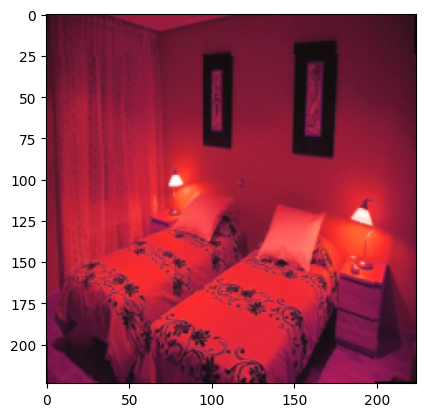

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print(f"Label:{dataset.classes[label]} (Class No: {label})")
    plt.imshow(img.permute(1, 2, 0))

img, label = dataset[666]
show_sample(img, label)

In [5]:
from torch.utils.data.dataloader import DataLoader

batch_size = 64
train_ds, val_ds, test_ds = random_split(dataset, [2800, 500, 383])
# print(f"train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

cuda


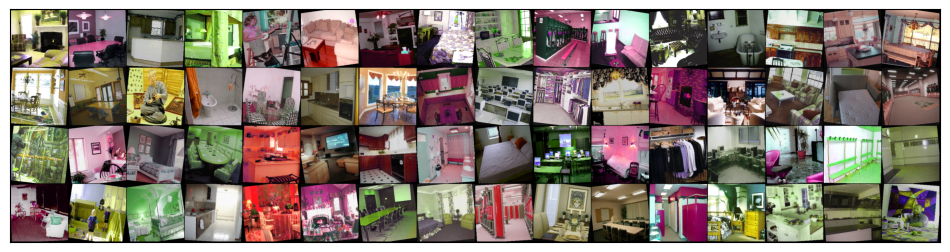

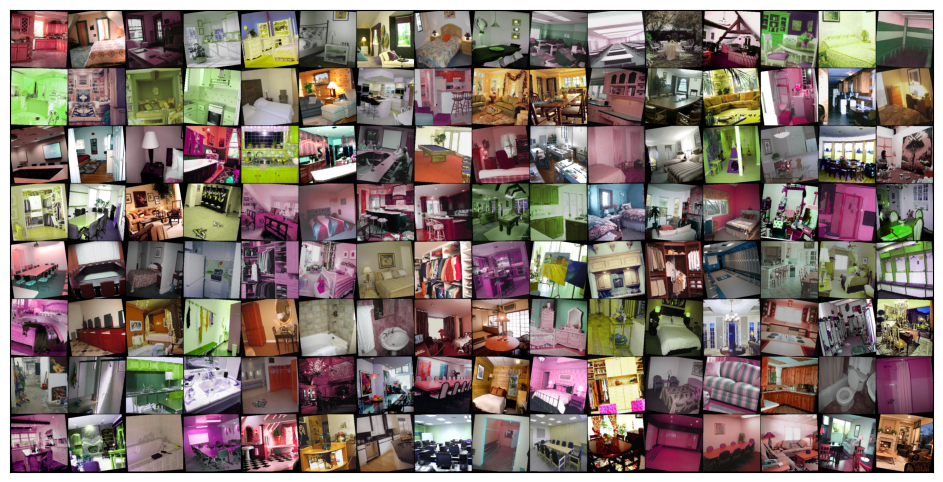

In [6]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

show_batch(train_loader)
show_batch(val_loader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    acc = torch.sum(preds == labels).item() / len(preds)
    return acc

class ConvClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torchvision.models.vit_b_16(pretrained=True)
        self.network.heads = nn.Linear(self.network.heads.head.in_features, len(dataset.classes))
        # self.network.fc = nn.Linear(self.network.fc.in_features, len(dataset.classes))
    
    def forward(self, xb):
        return self.network(xb)
    
    def training_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # cross entropy
        return loss
    
    @torch.no_grad()
    def valid_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device) 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.item(), 'val_acc': acc}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvClassifier().to(device)
optim = torch.optim.Adam(model.parameters(), 3e-5)

C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training the Model:

In [8]:
import numpy as np
history = []

In [9]:
num_epochs = 20

for epoch in range(num_epochs):  # Training Phase
    model.train()
    train_losses = []
    for batch in train_loader:
        loss = model.training_step(batch)
        optim.zero_grad()
        loss.backward()
        optim.step()

        train_losses.append(loss.item())

    # Validation phase
    model.eval()
    outputs = [model.valid_step(batch) for batch in val_loader]
    result = {
        'val_loss': np.mean([out['val_loss'] for out in outputs]), 
        'val_acc': np.mean([out['val_acc'] for out in outputs]), 
        'train_loss': np.mean(train_losses)
    }
    print(f"[Epoch {epoch+1}] train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
    history.append(result)

[Epoch 1] train_loss: 1.3522, val_loss: 0.7310, val_acc: 0.8074
[Epoch 2] train_loss: 0.5270, val_loss: 0.5450, val_acc: 0.8324
[Epoch 3] train_loss: 0.3276, val_loss: 0.5483, val_acc: 0.8291
[Epoch 4] train_loss: 0.2291, val_loss: 0.4828, val_acc: 0.8495
[Epoch 5] train_loss: 0.1810, val_loss: 0.5009, val_acc: 0.8411
[Epoch 6] train_loss: 0.1139, val_loss: 0.5399, val_acc: 0.8311
[Epoch 7] train_loss: 0.0897, val_loss: 0.5091, val_acc: 0.8473
[Epoch 8] train_loss: 0.0738, val_loss: 0.4786, val_acc: 0.8636
[Epoch 9] train_loss: 0.0567, val_loss: 0.5334, val_acc: 0.8514
[Epoch 10] train_loss: 0.0654, val_loss: 0.4790, val_acc: 0.8569
[Epoch 11] train_loss: 0.0427, val_loss: 0.5326, val_acc: 0.8596
[Epoch 12] train_loss: 0.0410, val_loss: 0.4779, val_acc: 0.8575
[Epoch 13] train_loss: 0.0450, val_loss: 0.4917, val_acc: 0.8633
[Epoch 14] train_loss: 0.0294, val_loss: 0.6380, val_acc: 0.8450
[Epoch 15] train_loss: 0.0211, val_loss: 0.5669, val_acc: 0.8499
[Epoch 16] train_loss: 0.0206, val

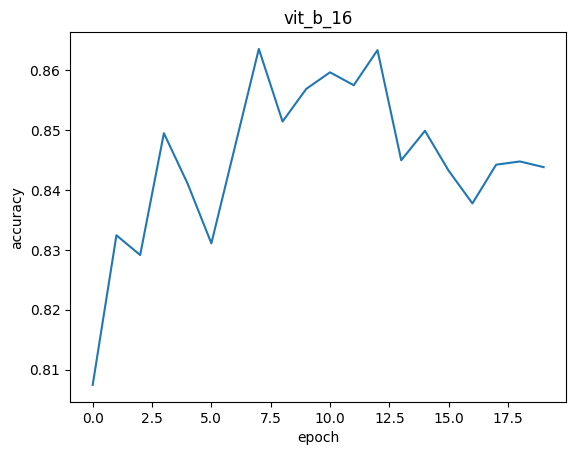

In [11]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('vit_b_16')

plot_accuracies(history)

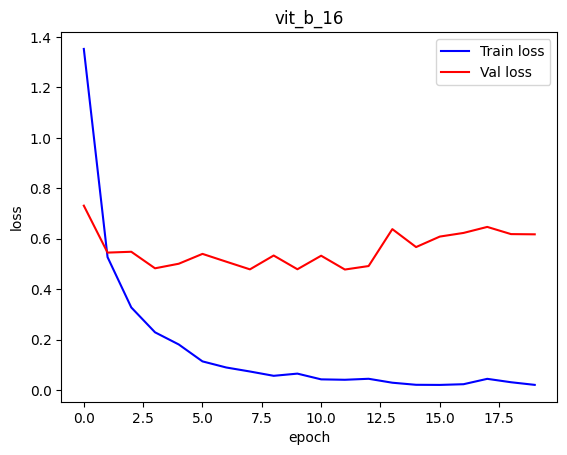

In [12]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Train loss', 'Val loss'])
    plt.title('vit_b_16');

plot_losses(history)

In [13]:
torch.save(model.state_dict(), "vit_b_16.pth")

In [14]:
model.load_state_dict(torch.load("vit_b_16.pth"))

C:\Users\DELL\AppData\Local\Temp\ipykernel_25700\2109308469.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("vit_b_16.pth"))


<All keys matched successfully>

# Visualizing Predictions:

In [15]:
def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)         # Convert to a batch of 1
    yb = model(xb)                           # Get predictions from model
    prob, preds  = torch.max(yb, dim=1)      # Pick index with highest probability
    return dataset.classes[preds[0].item()]  # Retrieve the class label

Let us see the model's predictions on the test dataset:

Label: livingroom , Predicted: livingroom


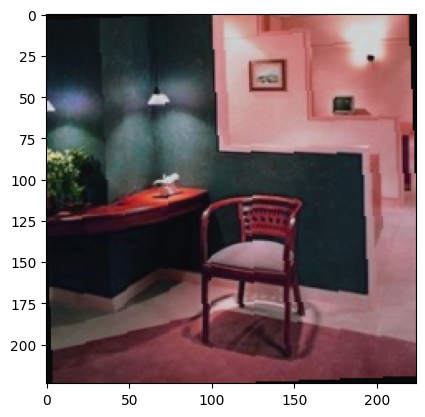

In [16]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: computerroom , Predicted: computerroom


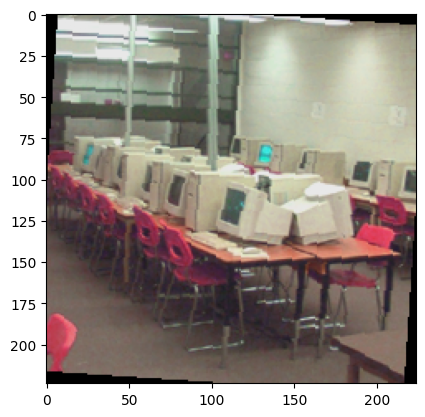

In [17]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: kitchen , Predicted: kitchen


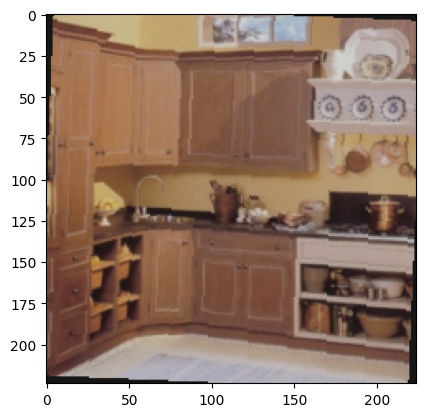

In [18]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# Predicting External Images:

Let's now test with external images.

I'll use `urllib` for downloading external images.

In [19]:
import urllib.request
# urllib.request.urlretrieve("https://images.squarespace-cdn.com/content/v1/5a7497e29f8dcee376b70f7e/1591630503059-FBBWAYXPWYOK9BTIBMZY/ke17ZwdGBToddI8pDm48kA_SSaoz4elkj-HsZd8gX3Z7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UWPwZyNcweDIvdeL5kotwkIXjs9g0WibSO_cU-Ijy4Pwg6poS-6WGGnXqDacZer4yQ/74586587_10157705983079085_1307946016988725248_o+%281%29.jpg?format=2500w", "bar.jpg")
# urllib.request.urlretrieve("https://www.bocadolobo.com/en/inspiration-and-ideas/wp-content/uploads/2018/03/Discover-the-Ultimate-Master-Bedroom-Styles-and-Inspirations-6_1.jpg", "bedroom.jpg")    
# urllib.request.urlretrieve("https://sika.scene7.com/is/image/sika/glo-elevator-appliances?wid=1280&crop=0%2C80%2C4615%2C3212", "elevator.jpg") 
urllib.request.urlretrieve("https://i.pinimg.com/originals/2b/15/9d/2b159da035e4e3aaa30c03ec8ba7816c.jpg", "gameroom.jpg")
# urllib.request.urlretrieve("https://i.pinimg.com/originals/a6/d9/d7/a6d9d743da7017a7bcf4a53e46d22f81.jpg", "inside_bus.jpg")
# urllib.request.urlretrieve("https://s.wsj.net/public/resources/images/ON-CE927_moviet_B1280_20170714200426.jpg", "theatre.jpg")

('gameroom.jpg', <http.client.HTTPMessage at 0x2459b1529f0>)

Let us load the model. You can load an external pre-trained model too!

In [20]:
loaded_model = model

This function takes the image's name and prints the predictions:

In [21]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

In [22]:
predict_external_image('bar.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\CS-7643 DL\\DesignGenie\\notebooks\\bar.jpg'

In [25]:
predict_external_image('bedroom.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\CS-7643 DL\\DesignGenie\\notebooks\\bedroom.jpg'

In [26]:
predict_external_image('elevator.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\CS-7643 DL\\DesignGenie\\notebooks\\elevator.jpg'

The image resembles computerroom.


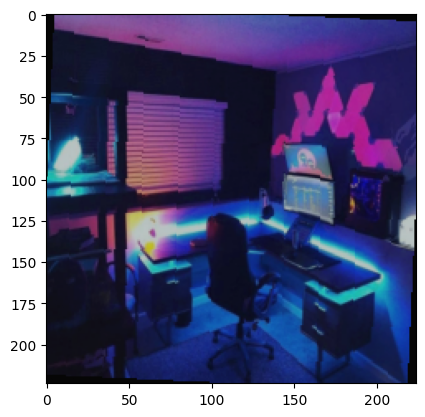

In [27]:
predict_external_image('gameroom.jpg')

In [28]:
predict_external_image('inside_bus.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\CS-7643 DL\\DesignGenie\\notebooks\\inside_bus.jpg'

In [24]:
predict_external_image('theatre.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\CS-7643 DL\\DesignGenie\\notebooks\\theatre.jpg'

# Conclusion:

Our model is able to classify indoor with **76% accuracy (max)**!

It's great to see the model's predictions on the test set. It works pretty good on external images too!

You can try experimenting with more images and see the results!

### If you liked the kernel, don't forget to show some appreciation :)